## 1. Define Data Path

In [3]:
from google.colab import drive
drive.mount('/content/my_google_drive')

Drive already mounted at /content/my_google_drive; to attempt to forcibly remount, call drive.mount("/content/my_google_drive", force_remount=True).


In [4]:
data_path = '/content/my_google_drive/MyDrive/Cell_data' # type in your path here!

## 2. Package download

In [5]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 3. Load packages

In [6]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import albumentations as A
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader
from torch.optim import Adam
from albumentations.pytorch.transforms import ToTensorV2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 4. Define Network 

In [7]:
model = smp.Unet(encoder_name="resnet34", in_channels=3, classes=2).to(device)

## 5. Dataset

In [19]:
def get_transforms(data_type='train'):
    if data_type=='train':
      # input_size = 160
      transformations = A.Compose([
        # A.RandomCrop(height=input_size, width=input_size, p=1.),
        # A.ShiftScaleRotate(p=0.7),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        A.Normalize(p=1.0),
        ToTensorV2(p=1.0),
      ], p=1.0)
    else:
      transformations = A.Compose([
        A.Normalize(p=1.0),
        ToTensorV2(p=1.0),
      ], p=1.0)
    return transformations

class CellDataset(nn.Module):
  def __init__(self, data_path, data_type='Train'):
    data_location = os.path.join(data_path, data_type)
    path_imgs  = sorted(glob.glob(os.path.join(data_location, 'imgs', '*.png')))
    path_masks = sorted(glob.glob(os.path.join(data_location, 'masks', '*.png')))
    self.n_imgs = len(path_imgs)
    self.imgs = np.zeros([self.n_imgs, 224, 224, 3])
    self.masks = np.zeros([self.n_imgs, 224, 224])
    for i in range(self.n_imgs):
      self.imgs[i] = np.array(Image.open(path_imgs[i]).convert('RGB'))
      self.masks[i] = (np.array(Image.open(path_masks[i]).convert('L')) > 0).astype(np.uint8)
    self.tfms = get_transforms(data_type)
    self.data_type = data_type

  def __len__(self):
    return self.n_imgs
  
  def __getitem__(self, idx):
    image  = self.imgs[idx]
    mask = self.masks[idx]

    augmented = self.tfms(image=image, mask=mask)
    aug_img, aug_mask = augmented['image'], augmented['mask']
    if self.data_type=='Test':
      return aug_img, aug_mask, image
    else:
      return aug_img, aug_mask



## 6. Training

In [11]:
smooth = 1e-6
def compute_dice(pre_image, gt_image):
  pre_image = torch.argmax(torch.softmax(pre_image, dim=1), dim=1).long()
  if torch.cuda.is_available():
    pre_image, gt_image = pre_image.cpu(), gt_image.cpu()
  
  pre_image, gt_image = pre_image.numpy(), gt_image.numpy()
  
  batch_size = pre_image.shape[0]

  pre_image = pre_image.reshape(batch_size, -1).astype(np.bool_)
  gt_image = gt_image.reshape(batch_size, -1).astype(np.bool_)

  intersection = (np.logical_and(pre_image, gt_image)).sum(axis=1)
  union = pre_image.sum(axis=1) + gt_image.sum(axis=1) + smooth
  dice = 2.*intersection / union

  return dice.mean()

In [21]:
# Train parameters
batch_size = 16
epochs = 5
learning_rate = 1e-4

# Dataset
train_dataset = CellDataset(data_path=data_path, data_type='Train')
valid_dataset = CellDataset(data_path=data_path, data_type='Valid')

# Data loader
train_loader = DataLoader(dataset=train_dataset, num_workers=2, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, num_workers=2, batch_size=batch_size, shuffle=False)

# Optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Loss function
criterion = nn.CrossEntropyLoss()

# Best score and epoch
best_dice = -np.inf
best_epoch = 0

# Path to save model
model_path = "best_params.pt"

for e in range(epochs):
  # Train
  model.train()
  loss_train = list()
  for batch_idx, (inputs, targets) in enumerate(train_loader):
    inputs = inputs.to(device)
    targets = targets.to(device).long()
    
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    loss_train.append(loss.item())
    optimizer.step()
  loss_train = np.array(loss_train).mean()
  print(f'[Train] epoch #{e}, loss: {loss_train:.4f}')

  # Validation
  model.eval()
  dice_epoch = list()
  with torch.no_grad():
    for inputs, targets in valid_loader:
      inputs = inputs.to(device)
      targets = targets.to(device).long()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      dice = compute_dice(outputs, targets)

      dice_epoch.append(dice)
    dice = np.array(dice_epoch).mean()
    print(f'[Valid] epoch #{e}, loss: {loss.item():.4f}, Dice score: {dice:.4f}')
    if dice > best_dice:
      best_dice = dice
      best_epoch = e
      # Save model
      torch.save(model.state_dict(), model_path)
print(f'[Training finished] Best dice score: {best_dice:.4f}, best epoch: {best_epoch}')
torch.save(model.state_dict(), model_path)

[Train] epoch #0, loss: 0.0196
(16,) (16,) (16,)
(16,) (16,) (16,)
(16,) (16,) (16,)
(16,) (16,) (16,)
[Valid] epoch #0, loss: 0.0188, Dice score: 0.8041
[Train] epoch #1, loss: 0.0166
(16,) (16,) (16,)
(16,) (16,) (16,)
(16,) (16,) (16,)
(16,) (16,) (16,)
[Valid] epoch #1, loss: 0.0176, Dice score: 0.8200
[Train] epoch #2, loss: 0.0133
(16,) (16,) (16,)
(16,) (16,) (16,)
(16,) (16,) (16,)
(16,) (16,) (16,)
[Valid] epoch #2, loss: 0.0176, Dice score: 0.8119
[Train] epoch #3, loss: 0.0118
(16,) (16,) (16,)
(16,) (16,) (16,)
(16,) (16,) (16,)
(16,) (16,) (16,)
[Valid] epoch #3, loss: 0.0153, Dice score: 0.8461
[Train] epoch #4, loss: 0.0104
(16,) (16,) (16,)
(16,) (16,) (16,)
(16,) (16,) (16,)
(16,) (16,) (16,)
[Valid] epoch #4, loss: 0.0165, Dice score: 0.8406
[Training finished] Best dice score: 0.8461, best epoch: 3


## 7. Inference

In [22]:
# Test dataset
test_dataset = CellDataset(data_path=data_path, data_type='Test')
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

# Load best parameters
model = smp.Unet(encoder_name="resnet34", in_channels=3, classes=2).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Inference
dice_total = list()
with torch.no_grad():
  for inputs, targets, orig in test_loader:
    inputs = inputs.to(device)
    targets = targets.to(device).long()
    outputs = model(inputs)
    dice_iter = compute_dice(outputs, targets)
    dice_total.append(dice_iter)
  dice = np.array(dice_total).mean()
  predictions = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
  print(f'[Inference] Dice score: {dice:.4f}')

(16,) (16,) (16,)
(16,) (16,) (16,)
(16,) (16,) (16,)
(16,) (16,) (16,)
[Inference] Dice score: 0.8330


## 8. Visualize Prediction

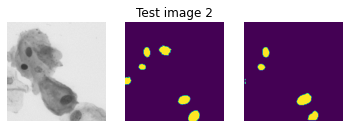

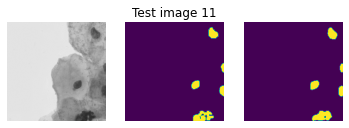

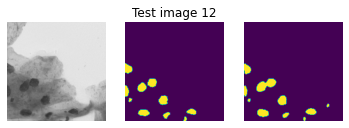

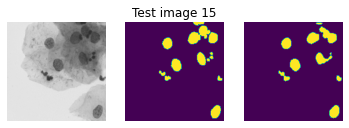

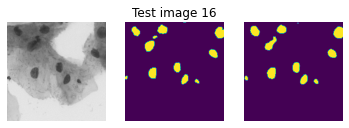

In [23]:
if torch.cuda.is_available():
  targets = targets.cpu()
  predictions = predictions.cpu()

index_to_check = [1, 10, 11, 14, 15]
test_imgs = (orig.numpy() / 255)
test_masks = (targets.numpy().astype(np.uint8))
test_results = (predictions.numpy().astype(np.uint8))

for idx, (img, mask, result) in enumerate(zip(test_imgs, test_masks, test_results)):
  if idx not in index_to_check:
    continue
  fig = plt.figure()  
  plt.subplot(1,3,1)
  plt.imshow(img)
  plt.axis('off')  
  plt.subplot(1,3,2)
  plt.imshow(mask)
  plt.axis('off')
  plt.title(f'Test image {idx+1}', loc='center')
  plt.subplot(1,3,3)
  plt.imshow(result)
  plt.axis('off')

## 9. Unmount google drive

In [18]:
# drive.flush_and_unmount()